In [1]:
%matplotlib inline
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

## Loading Data Incendie


In [2]:
df_incendie= pd.read_csv('./Data/Incendies.csv', sep=';', header=3)
df_incendie.shape

(27785, 24)

In [3]:
df_incendie.columns

Index(['Année', 'Numéro', 'Département', 'Code INSEE', 'Nom de la commune',
       'Date de première alerte', 'Surface parcourue (m2)',
       'Surface forêt (m2)', 'Surface maquis garrigues (m2)',
       'Autres surfaces naturelles hors forêt (m2)', 'Surfaces agricoles (m2)',
       'Autres surfaces (m2)', 'Surface autres terres boisées (m2)',
       'Surfaces non boisées naturelles (m2)',
       'Surfaces non boisées artificialisées (m2)',
       'Surfaces non boisées (m2)', 'Précision des surfaces',
       'Type de peuplement', 'Nature', 'Décès ou bâtiments touchés',
       'Nombre de décès', 'Nombre de bâtiments totalement détruits',
       'Nombre de bâtiments partiellement détruits', 'Précision de la donnée'],
      dtype='object')

In [4]:
df_incendie['Date de première alerte'] = pd.to_datetime(df_incendie['Date de première alerte'], errors='coerce')

In [5]:
df_incendie['Code INSEE'] = df_incendie['Code INSEE'].astype(str).str.zfill(5)

## Cleaning Data Incendie

In [6]:
df_incendie.rename(columns={
    'Code INSEE': 'code_insee',
    'Date de première alerte': 'date',
    'Surface parcourue (m2)': 'surf_brulee',
    'Surface forêt (m2)': 'surf_foret',
    'Surface maquis garrigues (m2)': 'surf_maquis',
    'Autres surfaces naturelles hors forêt (m2)': 'surf_autres_naturelles',
    'Surfaces agricoles (m2)': 'surf_agri',
    'Autres surfaces (m2)': 'surf_autres',
    'Surface autres terres boisées (m2)': 'surf_autres_bois',
    'Surfaces non boisées naturelles (m2)': 'surf_nb_nat',
    'Surfaces non boisées artificialisées (m2)': 'surf_nb_artif',
    'Surfaces non boisées (m2)': 'surf_nb_totale',
    'Type de peuplement': 'type_peuplement',
    'Nature': 'cause'
}, inplace=True)


In [7]:
colonnes_surfaces = [col for col in df_incendie.columns if 'surf' in col]
df_incendie[colonnes_surfaces] = df_incendie[colonnes_surfaces].fillna(0)

In [8]:
# Surface végétale potentielle (forêt + maquis + autres terres boisées)
df_incendie['surf_vegetale'] = (
    df_incendie['surf_foret'] +
    df_incendie['surf_maquis'] +
    df_incendie['surf_autres_bois']
)

# Ratio de végétation par rapport à la surface brûlée
df_incendie['ratio_vegetale'] = df_incendie['surf_vegetale'] / df_incendie['surf_brulee'].replace(0, 1)

df_incendie.head()


,Année,Numéro,Département,code_insee,Nom de la commune,date,surf_brulee,surf_foret,surf_maquis,surf_autres_naturelles,...,Précision des surfaces,type_peuplement,cause,Décès ou bâtiments touchés,Nombre de décès,Nombre de bâtiments totalement détruits,Nombre de bâtiments partiellement détruits,Précision de la donnée,surf_vegetale,ratio_vegetale
0,2015,5769,66,66100,Llo,2015-01-01 00:09:00,5000,5000.0,0.0,0.0,...,0,4.0,Involontaire (particulier),NaN,NaN,NaN,NaN,NaN,5000.0,1.0
1,2015,6760,07,07176,Planzolles,2015-01-01 13:13:00,10000,0.0,10000.0,0.0,...,0,1.0,Involontaire (particulier),NaN,NaN,NaN,NaN,NaN,10000.0,1.0
2,2015,12057,2A,2A362,Zonza,2015-01-01 15:16:00,4000,0.0,4000.0,0.0,...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4000.0,1.0
3,2015,6978,34,34260,Saint-Gervais-sur-Mare,2015-01-02 14:13:00,6450,6450.0,0.0,0.0,...,0,3.0,Involontaire (travaux),NaN,NaN,NaN,NaN,NaN,6450.0,1.0
4,2015,2,12,12270,Sévérac-le-Château,2015-01-02 19:19:00,50,0.0,0.0,50.0,...,Estimées,NaN,Involontaire (particulier),NaN,NaN,NaN,NaN,NaN,50.0,1.0


## Loading Data Meteo

In [9]:
df_meteo = pd.read_csv('Data/meteo.csv', sep=';')
df_meteo.shape

(14811, 60)

In [10]:
df_meteo.columns

Index(['numer_sta', 'date', 'pmer', 'tend', 'cod_tend', 'dd', 'ff', 't', 'td',
       'u', 'vv', 'ww', 'w1', 'w2', 'n', 'nbas', 'hbas', 'cl', 'cm', 'ch',
       'pres', 'niv_bar', 'geop', 'tend24', 'tn12', 'tn24', 'tx12', 'tx24',
       'tminsol', 'sw', 'tw', 'raf10', 'rafper', 'per', 'etat_sol', 'ht_neige',
       'ssfrai', 'perssfrai', 'rr1', 'rr3', 'rr6', 'rr12', 'rr24', 'phenspe1',
       'phenspe2', 'phenspe3', 'phenspe4', 'nnuage1', 'ctype1', 'hnuage1',
       'nnuage2', 'ctype2', 'hnuage2', 'nnuage3', 'ctype3', 'hnuage3',
       'nnuage4', 'ctype4', 'hnuage4', 'Unnamed: 59'],
      dtype='object')

In [11]:
# Sélection des colonnes utiles
df_meteo = df_meteo[['numer_sta', 'date', 'ff', 'raf10', 't', 'u', 'rr24']]

df_meteo['date'] = pd.to_datetime(df_meteo['date'].astype(str), format='%Y%m%d%H%M%S', errors='coerce')

cols_meteo = ['ff', 'raf10', 't', 'u', 'rr24']

# Remplacer 'mq' par NaN, puis convertir proprement en float
for col in cols_meteo:
    df_meteo[col] = pd.to_numeric(df_meteo[col].replace('mq', pd.NA), errors='coerce')
    
df_meteo.head()

,numer_sta,date,ff,raf10,t,u,rr24
0,7005,2015-01-01,2.8,3.6,272.55,89.0,0.0
1,7015,2015-01-01,2.4,3.0,272.85,100.0,0.0
2,7020,2015-01-01,10.8,15.1,279.95,88.0,0.0
3,7027,2015-01-01,2.8,3.4,270.65,92.0,0.0
4,7037,2015-01-01,1.3,1.9,270.65,95.0,0.0


In [12]:
# Pour température et humidité → remplacement simple
df_meteo['t'].fillna(df_meteo['t'].mean(), inplace=True)
df_meteo['u'].fillna(df_meteo['u'].mean(), inplace=True)

# Pour vitesse du vent (ff) → très peu de NaNs → suppression
df_meteo = df_meteo[df_meteo['ff'].notna()]

# Pour rafale (raf10) et pluie (rr24) → remplissage conservatif par 0
df_meteo['raf10'].fillna(0, inplace=True)
df_meteo['rr24'].fillna(0, inplace=True)

df_meteo.head()

,numer_sta,date,ff,raf10,t,u,rr24
0,7005,2015-01-01,2.8,3.6,272.55,89.0,0.0
1,7015,2015-01-01,2.4,3.0,272.85,100.0,0.0
2,7020,2015-01-01,10.8,15.1,279.95,88.0,0.0
3,7027,2015-01-01,2.8,3.4,270.65,92.0,0.0
4,7037,2015-01-01,1.3,1.9,270.65,95.0,0.0


In [13]:
df_meteo.info

<bound method DataFrame.info of        numer_sta                date    ff  raf10       t      u  rr24
0           7005 2015-01-01 00:00:00   2.8    3.6  272.55   89.0   0.0
1           7015 2015-01-01 00:00:00   2.4    3.0  272.85  100.0   0.0
2           7020 2015-01-01 00:00:00  10.8   15.1  279.95   88.0   0.0
3           7027 2015-01-01 00:00:00   2.8    3.4  270.65   92.0   0.0
4           7037 2015-01-01 00:00:00   1.3    1.9  270.65   95.0   0.0
...          ...                 ...   ...    ...     ...    ...   ...
14806      81401 2015-01-31 21:00:00   3.1    6.1  299.95   79.0   0.8
14807      81405 2015-01-31 21:00:00   5.8    8.2  300.65   77.0   2.8
14808      81408 2015-01-31 21:00:00   2.0    4.1  300.55   80.0  11.0
14809      81415 2015-01-31 21:00:00   0.6    1.9  298.75   91.0   2.8
14810      89642 2015-01-31 21:00:00   6.7    0.0  267.56   56.0   0.0

[14690 rows x 7 columns]>

## Loading Data Station_meteo

In [14]:
stations = pd.read_csv("./Data/meteo_station.txt", sep=';', encoding='utf-8')
stations.head()

,ID,Nom,Latitude,Longitude,Altitude
0,7005,ABBEVILLE,50.136000,1.834000,69
1,7015,LILLE-LESQUIN,50.570000,3.097500,47
2,7020,PTE DE LA HAGUE,49.725167,-1.939833,6
3,7027,CAEN-CARPIQUET,49.180000,-0.456167,67
4,7037,ROUEN-BOOS,49.383000,1.181667,151


In [15]:
# 1. Nettoyage et renommage
df_stations = stations.copy()
df_stations.rename(columns={
    'ID': 'numer_sta',
    'Nom': 'nom_station',
    'Latitude': 'latitude',
    'Longitude': 'longitude'
}, inplace=True)

# 2. Création de la géométrie (EPSG:4326 = WGS84)
geometry = gpd.points_from_xy(df_stations['longitude'], df_stations['latitude'])
df_stations = gpd.GeoDataFrame(df_stations, geometry=geometry, crs='epsg:4326')

# Aperçu
df_stations.head()

,numer_sta,nom_station,latitude,longitude,Altitude,geometry
0,7005,ABBEVILLE,50.136000,1.834000,69,POINT (1.83400 50.13600)
1,7015,LILLE-LESQUIN,50.570000,3.097500,47,POINT (3.09750 50.57000)
2,7020,PTE DE LA HAGUE,49.725167,-1.939833,6,POINT (-1.93983 49.72517)
3,7027,CAEN-CARPIQUET,49.180000,-0.456167,67,POINT (-0.45617 49.18000)
4,7037,ROUEN-BOOS,49.383000,1.181667,151,POINT (1.18167 49.38300)


In [16]:
df_meteo = df_meteo.merge(
    df_stations[['numer_sta', 'nom_station', 'geometry']],
    on='numer_sta',
    how='left'
)

df_meteo.tail()

,numer_sta,date,ff,raf10,t,u,rr24,nom_station,geometry
14685,81401,2015-01-31 21:00:00,3.1,6.1,299.95,79.0,0.8,SAINT LAURENT,POINT (-54.03167 5.48550)
14686,81405,2015-01-31 21:00:00,5.8,8.2,300.65,77.0,2.8,CAYENNE-MATOURY,POINT (-52.36533 4.82233)
14687,81408,2015-01-31 21:00:00,2.0,4.1,300.55,80.0,11.0,SAINT GEORGES,POINT (-51.80467 3.89067)
14688,81415,2015-01-31 21:00:00,0.6,1.9,298.75,91.0,2.8,MARIPASOULA,POINT (-54.02833 3.64017)
14689,89642,2015-01-31 21:00:00,6.7,0.0,267.56,56.0,0.0,DUMONT D'URVILLE,POINT (140.00100 -66.66317)


## Loading Data Communes

In [17]:
df_commune = gpd.read_file('./Data/commune.shp')  

print(df_commune.columns)
df_commune.head()

Index(['ID', 'NOM', 'NOM_M', 'INSEE_COM', 'STATUT', 'POPULATION', 'INSEE_CAN',
       'INSEE_ARR', 'INSEE_DEP', 'INSEE_REG', 'SIREN_EPCI', 'geometry'],
      dtype='object')


,ID,NOM,NOM_M,INSEE_COM,STATUT,POPULATION,INSEE_CAN,INSEE_ARR,INSEE_DEP,INSEE_REG,SIREN_EPCI,geometry
0,COMMUNE_0000000009738132,Guerlesquin,GUERLESQUIN,29067,Commune simple,1273,20,3,29,53,242900835,"POLYGON ((-3.59931 48.55848, -3.59910 48.55800..."
1,COMMUNE_0000000009754553,Saint-Astier,SAINT-ASTIER,24372,Commune simple,5320,17,3,24,75,200040095,"POLYGON ((0.46243 45.15564, 0.46239 45.15582, ..."
2,COMMUNE_0000000009729885,Balan,BALAN,08043,Commune simple,1612,16,3,08,44,200041630,"POLYGON ((4.95473 49.67238, 4.95432 49.67251, ..."
3,COMMUNE_0000000009744647,Vallons-de-l'Erdre,VALLONS-DE-L'ERDRE,44180,Commune simple,6559,01,5,44,52,244400552,"POLYGON ((-1.03906 47.54917, -1.03896 47.54892..."
4,COMMUNE_0000000009745513,Loireauxence,LOIREAUXENCE,44213,Commune simple,7517,01,5,44,52,244400552,"POLYGON ((-1.07254 47.50173, -1.07199 47.50199..."


In [18]:
df_commune = df_commune[['INSEE_COM', 'NOM', 'POPULATION', 'geometry']].copy()
df_commune.rename(columns={
    'INSEE_COM': 'code_insee',
    'NOM': 'nom_commune'
}, inplace=True)

df_commune['code_insee'] = df_commune['code_insee'].astype(str).str.zfill(5)

# 1. Définir le CRS d'origine si absent (probablement Lambert 93)
df_commune.set_crs(epsg=2154, inplace=True)

# 2. Convertir vers WGS84 (EPSG:4326)
df_commune = df_commune.to_crs(epsg=4326)


df_commune.head()

,code_insee,nom_commune,POPULATION,geometry
0,29067,Guerlesquin,1273,"POLYGON ((-1.36312 -5.98356, -1.36312 -5.98356..."
1,24372,Saint-Astier,5320,"POLYGON ((-1.36309 -5.98357, -1.36309 -5.98357..."
2,08043,Balan,1612,"POLYGON ((-1.36307 -5.98355, -1.36307 -5.98355..."
3,44180,Vallons-de-l'Erdre,6559,"POLYGON ((-1.36310 -5.98356, -1.36310 -5.98356..."
4,44213,Loireauxence,7517,"POLYGON ((-1.36310 -5.98356, -1.36310 -5.98356..."


## Fusion des données

In [21]:
df_commune = df_commune.to_crs(epsg=4326)
df_stations = df_stations.to_crs(epsg=4326)
from scipy.spatial import cKDTree
import numpy as np

# Extraire les coordonnées
commune_coords = np.array(list(df_commune.geometry.centroid.apply(lambda geom: (geom.x, geom.y))))
station_coords = np.array(list(df_stations.geometry.apply(lambda geom: (geom.x, geom.y))))

# Construction du KDTree et recherche de la plus proche
tree = cKDTree(station_coords)
distances, indices = tree.query(commune_coords, k=1)

# Ajouter l'identifiant de la station la plus proche
df_commune['nearest_station'] = df_stations.iloc[indices]['numer_sta'].values.astype(int)

C:\Users\PC\AppData\Local\Temp\ipykernel_18672\1005048656.py:7: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  commune_coords = np.array(list(df_commune.geometry.centroid.apply(lambda geom: (geom.x, geom.y))))


In [22]:
import pandas as pd

# 1. Nettoyage des colonnes INSEE et station
df_commune['code_insee'] = df_commune['code_insee'].astype(str).str.zfill(5)
df_commune['nearest_station'] = df_commune['nearest_station'].astype(int)
df_meteo['numer_sta'] = df_meteo['numer_sta'].astype(int)

# 2. Conversion des dates
df_meteo['date'] = pd.to_datetime(df_meteo['date'], errors='coerce')
df_incendie['date'] = pd.to_datetime(df_incendie['date'], errors='coerce')

# 3. Création de df_meteo_clean (colonnes utiles)
df_meteo_clean = df_meteo[['numer_sta', 'date', 'ff', 'raf10', 't', 'u', 'rr24']].copy()

# 4. Base commune avec stations météo les plus proches
df_base = df_commune[['code_insee', 'nearest_station']].copy()

# 5. Fusion : produit croisé (commune × chaque jour de météo de sa station)
df_commune_meteo = df_base.merge(
    df_meteo_clean,
    left_on='nearest_station',
    right_on='numer_sta',
    how='left'
)

# 6. Nettoyage des lignes sans date (par sécurité)
df_commune_meteo = df_commune_meteo[df_commune_meteo['date'].notna()]
df_incendie = df_incendie[df_incendie['date'].notna()]

In [23]:
# Base commune
df_base = df_commune[['code_insee', 'nearest_station']].copy()

# Fusion : produit croisé commune × météo de sa station
df_commune_meteo = df_base.merge(
    df_meteo_clean,
    left_on='nearest_station',
    right_on='numer_sta',
    how='left'
)

# Supprimer les lignes sans date
df_commune_meteo = df_commune_meteo[df_commune_meteo['date'].notna()]


In [24]:
# Harmoniser les codes INSEE
df_incendie['code_insee'] = df_incendie['code_insee'].astype(str).str.zfill(5)

# Créer une clé : code_insee + date
df_incendie['key'] = df_incendie['code_insee'] + '_' + df_incendie['date'].dt.strftime('%Y-%m-%d')
df_commune_meteo['key'] = df_commune_meteo['code_insee'] + '_' + df_commune_meteo['date'].dt.strftime('%Y-%m-%d')

# Génération du label (1 si incendie dans la commune ce jour-là)
df_commune_meteo['label'] = df_commune_meteo['key'].isin(df_incendie['key']).astype(int)

In [25]:
print(df_commune_meteo['label'].value_counts())
print(df_commune_meteo[['date', 'label']].drop_duplicates().head())

label
0    8663136
1        744
Name: count, dtype: int64
                 date  label
0 2015-01-01 00:00:00      0
1 2015-01-01 03:00:00      0
2 2015-01-01 06:00:00      0
3 2015-01-01 09:00:00      0
4 2015-01-01 12:00:00      0


In [26]:
# Définir les colonnes features
features = ['ff', 'raf10', 't', 'u', 'rr24']

# Supprimer les lignes avec valeurs manquantes
df_model = df_commune_meteo.dropna(subset=features + ['label'])

# Créer X et y
X = df_model[features]
y = df_model['label']
# Séparer les classes
df_positives = df_model[df_model['label'] == 1]
df_negatives = df_model[df_model['label'] == 0].sample(n=len(df_positives), random_state=42)

# Fusionner et mélanger
df_balanced = pd.concat([df_positives, df_negatives]).sample(frac=1, random_state=42)

# Redéfinir X et y équilibrés
X_balanced = df_balanced[features]
y_balanced = df_balanced['label']

## Random Forest Classification

In [27]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# Split train/test
X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, stratify=y_balanced, test_size=0.2, random_state=42)

# Modèle
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Prédiction + évaluation
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.67      0.64      0.65       149
           1       0.65      0.68      0.67       149

    accuracy                           0.66       298
   macro avg       0.66      0.66      0.66       298
weighted avg       0.66      0.66      0.66       298

[[ 95  54]
 [ 47 102]]


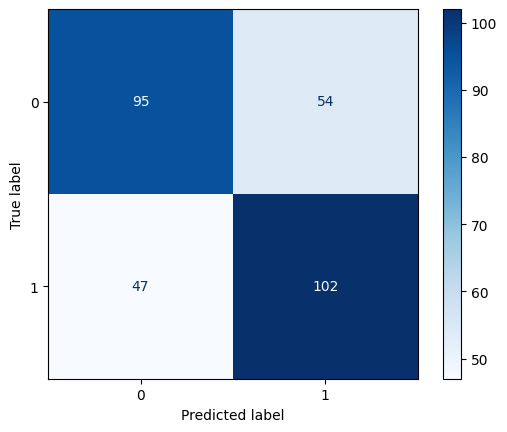

In [28]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, cmap='Blues')


In [31]:
from sklearn.metrics import classification_report, confusion_matrix

# Obtenir les scores
report = classification_report(y_test, y_pred, output_dict=True)
df_report = pd.DataFrame(report).transpose()

# Matrice de confusion
cm = confusion_matrix(y_test, y_pred)

# Affichage console
print("Confusion Matrix:")
print(cm)

print("\nClassification Report:")
print(df_report.round(2))


Confusion Matrix:
[[ 95  54]
 [ 47 102]]

Classification Report:
              precision  recall  f1-score  support
0                  0.67    0.64      0.65   149.00
1                  0.65    0.68      0.67   149.00
accuracy           0.66    0.66      0.66     0.66
macro avg          0.66    0.66      0.66   298.00
weighted avg       0.66    0.66      0.66   298.00


## XGBoost

In [33]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix

X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.3, random_state=42)

xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train, y_train)

y_pred_proba = xgb_model.predict_proba(X_test)[:, 1]
y_pred = xgb_model.predict(X_test)

roc_auc = roc_auc_score(y_test, y_pred_proba)
report = classification_report(y_test, y_pred, output_dict=False)
conf_matrix = confusion_matrix(y_test, y_pred)

c:\Users\PC\anaconda3\envs\project_ml_env\lib\site-packages\xgboost\core.py:158: UserWarning: [22:23:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [34]:
def display_model_results(auc, report, matrix):
    print(f"\n📊 Évaluation XGBoost\nROC AUC : {auc:.3f}\n\n{report}\n")
    return pd.DataFrame(matrix, index=["Classe 0", "Classe 1"], columns=["Prédit 0", "Prédit 1"])

display_model_results(roc_auc, report, conf_matrix)


📊 Évaluation XGBoost
ROC AUC : 0.694

              precision    recall  f1-score   support

           0       0.65      0.57      0.61       230
           1       0.60      0.68      0.64       217

    accuracy                           0.62       447
   macro avg       0.63      0.63      0.62       447
weighted avg       0.63      0.62      0.62       447




,Prédit 0,Prédit 1
Classe 0,132,98
Classe 1,70,147


## LightGBM

In [35]:
!pip install lightgbm

   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   ---------------------------------------- 1.5/1.5 MB 10.8 MB/s eta 0:00:00


In [36]:
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix
import pandas as pd
X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.3, random_state=42)

# Initialisation du modèle
model = LGBMClassifier(random_state=42)

# Entraînement
model.fit(X_train, y_train)

# Prédiction des classes et des probabilités
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

[LightGBM] [Info] Number of positive: 527, number of negative: 514
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000091 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 136
[LightGBM] [Info] Number of data points in the train set: 1041, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506244 -> initscore=0.024977
[LightGBM] [Info] Start training from score 0.024977


In [37]:
# Évaluation
print("Évaluation LightGBM")
print(f"ROC AUC Score : {roc_auc_score(y_test, y_proba):.3f}\n")
print("Classification Report :\n", classification_report(y_test, y_pred))
print("Matrice de Confusion :\n", confusion_matrix(y_test, y_pred))

Évaluation LightGBM
ROC AUC Score : 0.702

Classification Report :
               precision    recall  f1-score   support

           0       0.66      0.61      0.64       230
           1       0.62      0.66      0.64       217

    accuracy                           0.64       447
   macro avg       0.64      0.64      0.64       447
weighted avg       0.64      0.64      0.64       447

Matrice de Confusion :
 [[141  89]
 [ 73 144]]


## Prédiction gravité d'un incendie.

In [62]:
df_incendie= pd.read_csv('./Data/Incendies.csv', sep=';', header=3)
colonnes_utiles = [
    'Année',
    'Numéro',
    'Département',
    'Code INSEE',
    'Date de première alerte',
    'Surface parcourue (m2)',  
    'Surface forêt (m2)',
    'Surface maquis garrigues (m2)',
    'Autres surfaces naturelles hors forêt (m2)',
    'Surface autres terres boisées (m2)',
    'Surfaces non boisées naturelles (m2)',
    'Surfaces non boisées artificialisées (m2)',
    'Surfaces non boisées (m2)'
]

incendie = df_incendie[colonnes_utiles].copy()

In [63]:
incendie.fillna(0, inplace=True)
# Suppression des colonnes redondantes après fusion manuelle des surfaces boisées et non boisées
incendie.drop(['Surface autres terres boisées (m2)','Surfaces non boisées (m2)'], axis=1, inplace=True)

incendie.rename(columns={
    'Année': 'annee',
    'Numéro': 'id_inc',
    'Département': 'dep',
    'Code INSEE': 'code_insee',
    'Date de première alerte': 'date',
    'Surface parcourue (m2)': 'surf_brulee',
    'Surface forêt (m2)': 'surf_foret',
    'Surface maquis garrigues (m2)': 'surf_maquis',
    'Autres surfaces naturelles hors forêt (m2)': 'autre_surf',
    'Surface autres terres boisées (m2)': 'surf_autres_bois',
    'Surfaces non boisées naturelles (m2)': 'surf_nb_naturelle',
    'Surfaces non boisées artificialisées (m2)': 'surf_nb_artificielle',
    'Surfaces non boisées (m2)': 'surf_nb_totale'
}, inplace=True)


incendie.drop_duplicates(['date','id_inc']).shape

incendie.drop_duplicates(['code_insee','id_inc']).shape

# On enlève les départements corses
incendie = incendie[~incendie['code_insee'].astype(str).str.startswith(('2A', '2B'))]

# On convertit la colonne code_insee en entier
incendie['code_insee'] = incendie['code_insee'].astype(int)
# Regroupement des départements d’Île-de-France sous le code de Paris ('75'), comme dans les données IGN sauf pour la Seine-et-Marne 
incendie.loc[
    (incendie.dep == '75') |
    (incendie.dep == '91') |
    (incendie.dep == '92') |
    (incendie.dep == '93') |
    (incendie.dep == '94') |
    (incendie.dep == '95') |
    (incendie.dep == '78'),
    'dep'
] = '75'
# Convertir les dates en datetime
incendie['date'] = incendie.date.apply(lambda _: dt.datetime.strptime(_,"%Y-%m-%d %H:%M:%S"))

In [65]:
df = incendie.copy()
df['month'] = pd.to_datetime(df['date']).dt.month
df['day'] = pd.to_datetime(df['date']).dt.day
df['dayofweek'] = pd.to_datetime(df['date']).dt.dayofweek

X = df[['dep', 'code_insee', 'surf_foret',
        'surf_nb_naturelle', 'surf_nb_artificielle',
      'month', 'day', 'dayofweek']].copy()

y = df['surf_brulee']

from sklearn.preprocessing import LabelEncoder
for col in ['dep', 'code_insee']:
    X[col] = LabelEncoder().fit_transform(X[col])

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [66]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score

# Modèle simple
linreg = LinearRegression()
linreg.fit(X_train, y_train)

# Prédictions
y_pred_lin = linreg.predict(X_test)

# Évaluation
print("Linear Regression")
print("Mean absolute Error:", mean_absolute_error(y_test, y_pred_lin))
print("R²:", r2_score(y_test, y_pred_lin))

Linear Regression
Mean absolute Error: 43554.42907529078
R²: 0.9459409537037373


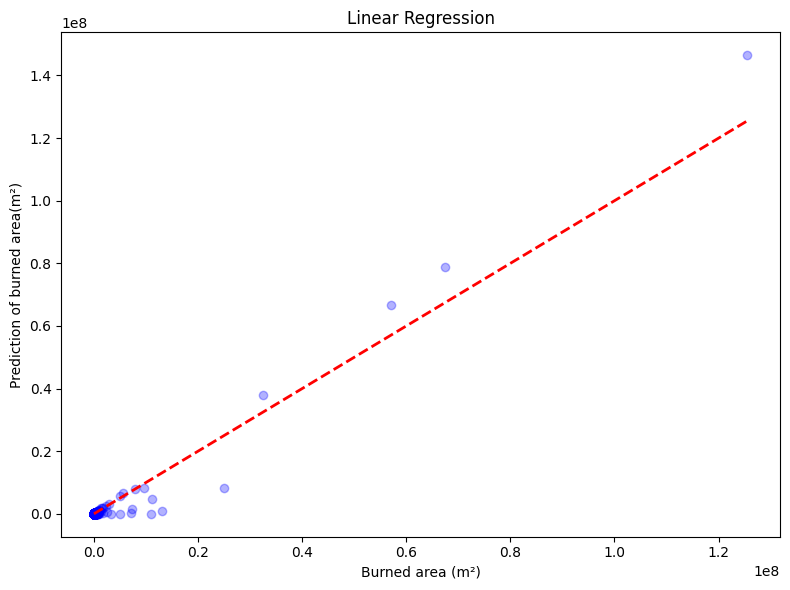

In [67]:
import matplotlib.pyplot as plt


y_pred_lin = linreg.predict(X_test)

# Plotting
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_lin, alpha=0.3, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', linewidth=2)
plt.xlabel("Burned area (m²)")
plt.ylabel("Prediction of burned area(m²)")
plt.title("Linear Regression")
plt.tight_layout()
plt.show()

In [68]:
from sklearn.ensemble import RandomForestRegressor

# Modèle avancé
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Prédictions
y_pred_rf = rf.predict(X_test)

# Évaluation
print("Random Forest Regressor")
print("Mean absolute Error:", mean_absolute_error(y_test, y_pred_rf))
print("R²:", r2_score(y_test, y_pred_rf))

Random Forest Regressor
Mean absolute Error: 53880.86700577883
R²: 0.7530067008675141


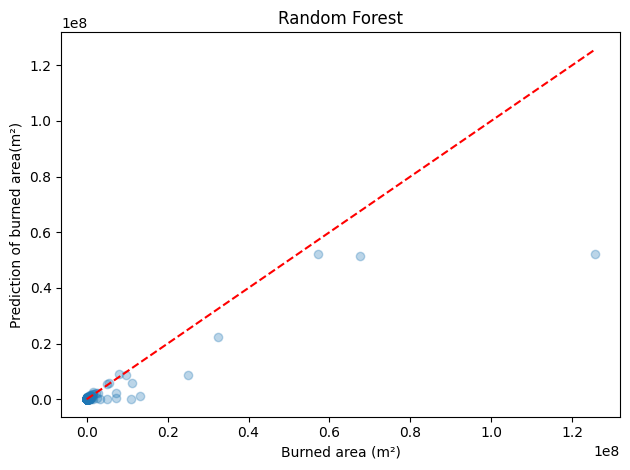

In [69]:
import matplotlib.pyplot as plt

plt.scatter(y_test, y_pred_rf, alpha=0.3)
plt.xlabel("Burned area (m²)")
plt.ylabel("Prediction of burned area(m²)")
plt.title("Random Forest")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.tight_layout()
plt.show()